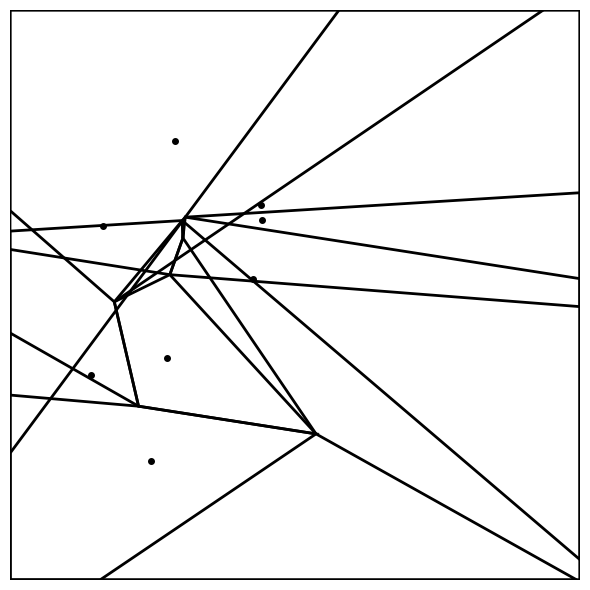

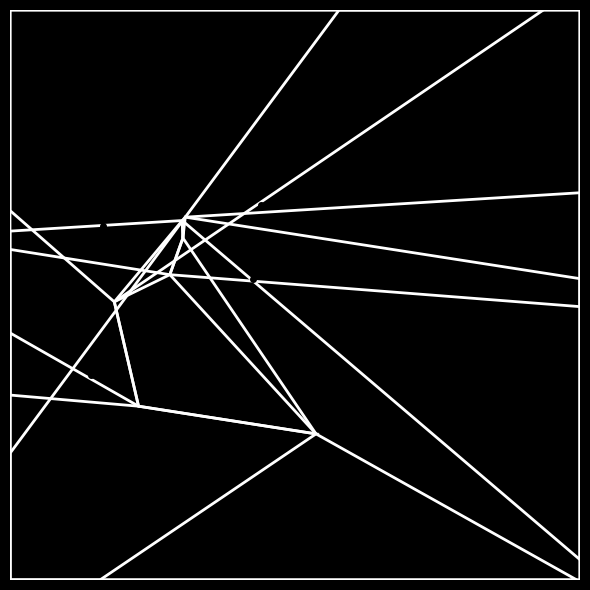

In [14]:
#@title Voronoi Edges

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from shapely.geometry import Polygon as ShapelyPolygon
from shapely.geometry import box as shapely_box
from shapely.ops import unary_union
from matplotlib.patches import Polygon as MplPolygon

# ---- helper to turn infinite Voronoi regions into finite polygons
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct finite Voronoi polygons for all regions in a Voronoi diagram.
    Returns list of polygons as lists of (x,y) coords and the corresponding point index.
    """
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")
    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max() * 2

    # Map ridge vertices to ridges for each point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    for p_idx, region_idx in enumerate(vor.point_region):
        region = vor.regions[region_idx]
        if -1 not in region:
            # finite region
            new_regions.append([vor.vertices[i].tolist() for i in region])
            continue
        # reconstruct a region for point p_idx
        ridges = all_ridges[p_idx]
        pts = []
        for p2, v1, v2 in ridges:
            if v2 < 0 or v1 < 0:
                # one infinite endpoint — compute a far point
                v = vor.vertices[[v for v in (v1, v2) if v != -1][0]]
                tangent = vor.points[p2] - vor.points[p_idx]
                tangent /= np.linalg.norm(tangent)
                normal = np.array([-tangent[1], tangent[0]])
                far_point = v + normal * radius
                pts.append((v.tolist(), far_point.tolist()))
        # collect finite vertices + far points; simpler: compute convex hull of region's vertices plus far points
        region_pts = [vor.vertices[i].tolist() for i in region if i != -1]
        for a,b in pts:
            region_pts.append(b)
        # order points around centroid
        region_pts = np.array(region_pts)
        c = region_pts.mean(axis=0)
        angles = np.arctan2(region_pts[:,1]-c[1], region_pts[:,0]-c[0])
        order = np.argsort(angles)
        region_ordered = region_pts[order].tolist()
        new_regions.append(region_ordered)
    return new_regions

# ---- parameters
np.random.seed(1)
n_points = 8
points = np.random.rand(n_points, 2) * 5  # 0..5 square
bbox = shapely_box(-1, -1, 6, 6)          # bounding box to clip to
edge_thickness = 2.0

# compute Voronoi and finite polygons
vor = Voronoi(points)
polygons = voronoi_finite_polygons_2d(vor, radius=100.0)

# clip each polygon to bbox and keep shapely polygons
shapely_polys = []
for poly_coords in polygons:
    sp = ShapelyPolygon(poly_coords)
    clipped = sp.intersection(bbox)
    if not clipped.is_empty and clipped.area > 1e-9:
        # clipped might be Polygon or MultiPolygon; normalize to list of Polygons
        if hasattr(clipped, "geoms"):
            for g in clipped.geoms:
                if g.area > 0:
                    shapely_polys.append(g)
        else:
            shapely_polys.append(clipped)

# --- plotting function that draws ONLY edges (facecolor='none')
def save_voronoi_edges(polys, edge_color, filename, fig_bg="white"):
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_aspect('equal')
    ax.set_xlim(-1, 6)
    ax.set_ylim(-1, 6)
    fig.patch.set_facecolor(fig_bg)
    ax.set_facecolor(fig_bg)

    for p in polys:
        # use a Matplotlib patch with facecolor='none' so only edges are drawn
        coords = list(p.exterior.coords)
        patch = MplPolygon(coords, closed=True,
                           facecolor='none', edgecolor=edge_color,
                           linewidth=edge_thickness, zorder=2)
        ax.add_patch(patch)
        # if polygon has holes, draw their edges too
        for interior in p.interiors:
            hole = MplPolygon(list(interior.coords), closed=True,
                              facecolor='none', edgecolor=edge_color,
                              linewidth=edge_thickness, zorder=2)
            ax.add_patch(hole)

    # also draw original generating points (optional)
    ax.plot(points[:,0], points[:,1], 'o', color='black', markersize=4, zorder=3)
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(filename, format='svg', facecolor=fig.get_facecolor())
    plt.show()
    plt.close(fig)

# Save 1: black edges on white background
save_voronoi_edges(shapely_polys, edge_color='black', filename='voronoi_black_edges.svg', fig_bg='white')

# Save 2: white edges on black background (so white edges are visible)
save_voronoi_edges(shapely_polys, edge_color='white', filename='voronoi_white_edges_black_bg.svg', fig_bg='black')


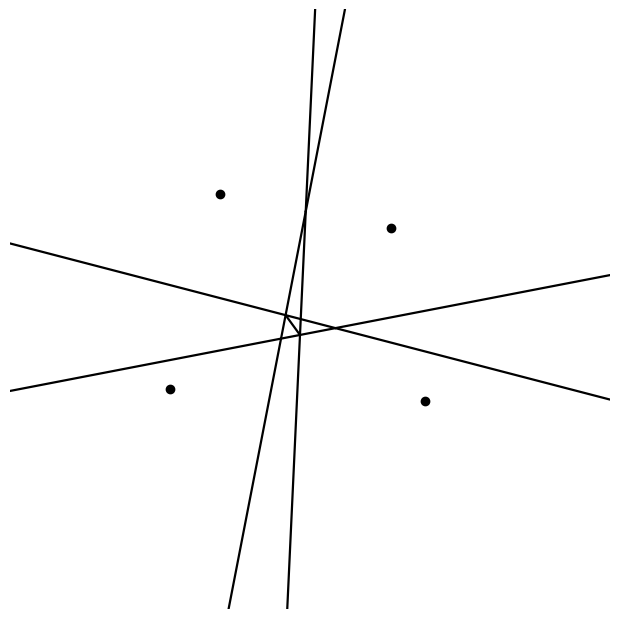

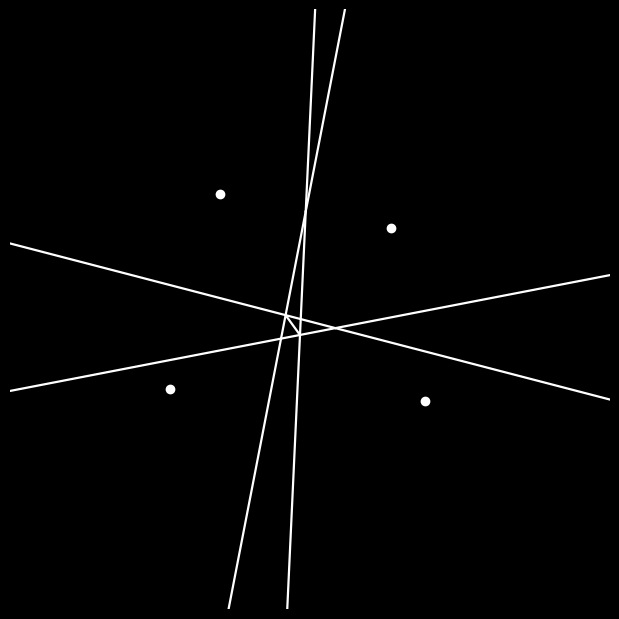

Points used: 4. Segments drawn: 5


In [25]:
#@title Voronoi Edges 2 (make a SVG with this)

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from shapely.geometry import LineString
from shapely.geometry import box as shapely_box
from matplotlib.patches import Polygon as MplPolygon
from shapely.ops import unary_union

# -------------------------
# Utilities
# -------------------------
def jittered_grid_points(n_points, x0=0.0, x1=5.0, y0=0.0, y1=5.0, jitter_frac=0.3, seed=None):
    if seed is not None:
        np.random.seed(seed)
    k = int(np.ceil(np.sqrt(n_points)))
    nx, ny = k, k
    xs = np.linspace(x0, x1, nx+1)
    ys = np.linspace(y0, y1, ny+1)
    centers = []
    for i in range(nx):
        for j in range(ny):
            cx = 0.5*(xs[i]+xs[i+1])
            cy = 0.5*(ys[j]+ys[j+1])
            centers.append((cx, cy, xs[i+1]-xs[i], ys[j+1]-ys[j]))
    chosen = np.random.choice(len(centers), size=n_points, replace=False)
    pts = []
    for idx in chosen:
        cx, cy, cw, ch = centers[idx]
        jitter_x = (np.random.rand() - 0.5) * cw * jitter_frac
        jitter_y = (np.random.rand() - 0.5) * ch * jitter_frac
        pts.append([cx + jitter_x, cy + jitter_y])
    return np.array(pts)

# -------------------------
# Parameters (vous pouvez ajuster n_points)
# -------------------------
n_points = 4
seed = 42
np.random.seed(seed)
points = jittered_grid_points(n_points, x0=0.0, x1=5.0, y0=0.0, y1=5.0,
                              jitter_frac=0.35, seed=seed)

bbox = shapely_box(-1, -1, 6, 6)
edge_thickness = 1.6

# -------------------------
# Build Voronoi and extract/clipped ridges robustly
# -------------------------
vor = Voronoi(points)

lines = []  # list of shapely LineString clipped to bbox

R = 1e3  # large distance for extending infinite ridges (will be intersected with bbox)

for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
    # endpoints indices v1, v2 refer to vor.vertices; -1 means infinite
    if v1 >= 0 and v2 >= 0:
        # finite segment between two Voronoi vertices
        seg = LineString([vor.vertices[v1], vor.vertices[v2]])
        clipped = seg.intersection(bbox)
        if not clipped.is_empty:
            # clipped may be LineString or MultiLineString
            if clipped.geom_type == "LineString":
                lines.append(clipped)
            else:
                for g in clipped.geoms:
                    if g.geom_type == "LineString":
                        lines.append(g)
    else:
        # infinite ridge: construct perpendicular bisector line through the finite vertex (or through midpoint)
        pA = vor.points[p1]
        pB = vor.points[p2]
        mid = 0.5 * (pA + pB)
        # direction from pA to pB
        v = pB - pA
        norm = np.linalg.norm(v)
        if norm == 0:
            continue
        v = v / norm
        # perpendicular direction
        perp = np.array([-v[1], v[0]])
        # build a long segment centered on midpoint along perp
        far1 = mid + perp * R
        far2 = mid - perp * R
        seg = LineString([far1, far2])
        clipped = seg.intersection(bbox)
        if not clipped.is_empty:
            if clipped.geom_type == "LineString":
                lines.append(clipped)
            else:
                for g in clipped.geoms:
                    if g.geom_type == "LineString":
                        lines.append(g)

# unify (optional) to merge touching segments
E = unary_union(lines)

# -------------------------
# Save function : dessine uniquement les arêtes (facecolor none), pas de contours
# -------------------------
def save_edges_from_union(E, edge_color, filename, fig_bg='white', show_points=False):
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_aspect('equal')
    ax.set_xlim(-1, 6)
    ax.set_ylim(-1, 6)
    fig.patch.set_facecolor(fig_bg)
    ax.set_facecolor(fig_bg)

    # E may be LineString or MultiLineString
    if E.geom_type == "LineString":
        segments = [E]
    elif E.geom_type in ("MultiLineString", "GeometryCollection"):
        segments = [g for g in E.geoms if g.geom_type == "LineString"]
    else:
        segments = []

    for seg in segments:
        x, y = seg.xy
        ax.plot(x, y, linewidth=edge_thickness, solid_capstyle='round',
                color=edge_color, zorder=2)

    if show_points:
        ax.plot(points[:,0], points[:,1], 'o', color='black' if fig_bg=='white' else 'white', zorder=3)

    ax.set_axis_off()
    plt.tight_layout(pad=0)
    plt.savefig(filename, format='svg', facecolor=fig.get_facecolor(), bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close(fig)

# -------------------------
# Save two variants (no outer contour)
# -------------------------
save_edges_from_union(E, edge_color='black', filename='voronoi_black_edges.svg', fig_bg='white', show_points=True)
save_edges_from_union(E, edge_color='white', filename='voronoi_white_edges_black_bg.svg', fig_bg='black', show_points=True)

print(f"Points used: {len(points)}. Segments drawn: {len(lines)}")
